In [153]:
import time
import cv2
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['figure.figsize'] = [16, 14]

In [154]:
def show(img):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [155]:
with open('coco.names', 'r') as f:
    coco_names = f.readlines()

class_names = [name.rstrip() for name in coco_names]
print(class_names)

['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


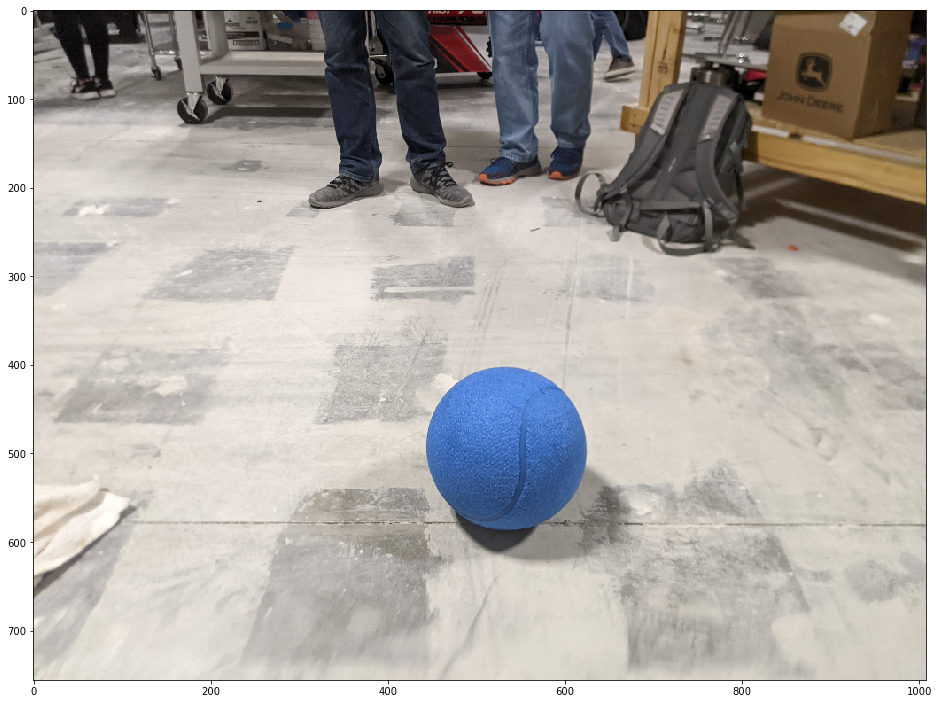

In [156]:
img = cv2.imread('data/PXL_20220111_235304810.jpg')
h, w, _ = img.shape
img = cv2.resize(img, (w//4, h//4))
show(img)

In [157]:
net = cv2.dnn.readNetFromONNX('best.onnx')

In [158]:
#dnn.setInputSize(640, 640)
#dnn.setInputSwapRB(True)
#dnn.setNmsAcrossClasses(True)
#dnn.setInputScale(1/255.0)
#classids, conf, boxes = dnn.detect(img, 0.8, 0.4)

# put the image in square big enough
tstart = time.time()
new_width = int(img.shape[1] / (img.shape[0] / 640))
print(new_width)
small = cv2.resize(img, (new_width, 640))
center = new_width // 2
crop = small[:, center - 320:center + 320]
print(small.shape)
blob = cv2.dnn.blobFromImage(crop, 1/255.0, swapRB=True, size=(640,640))
print(blob.shape)
net.setInput(blob)
out = net.forward()
tstop = time.time()
print(f'Inference took {tstop - tstart:01.3} seconds')


853
(640, 853, 3)
(1, 3, 640, 640)
Inference took 0.118 seconds


In [159]:
def unwrap_detection(input_image, output_data):
    class_ids = []
    confidences = []
    boxes = []

    image_width, image_height, _ = input_image.shape

    x_factor = image_width / 640
    y_factor =  image_height / 640
    #x_factor = y_factor
    #y_factor = 1

    for row in output_data:
        confidence = row[4]
        if confidence >= 0.4:
            classes_scores = row[5:]
            _, _, _, max_indx = cv2.minMaxLoc(classes_scores)
            class_id = max_indx[1]
            #print(f'Conf: {confidence} class: {classes_scores} classid: {class_id}')
            if (classes_scores[class_id] > .25):
                confidences.append(confidence)

                class_ids.append(class_id)

                x, y, w, h = row[0].item(), row[1].item(), row[2].item(), row[3].item() 
                left = int((x - 0.5 * w) * x_factor)
                top = int((y - 0.5 * h) * y_factor)
                width = int(w * x_factor)
                height = int(h * y_factor)
                box = np.array([left, top, width, height])
                boxes.append(box)
    return class_ids, confidences, boxes

In [160]:
classid, conf, boxes = unwrap_detection(crop, out[0])
print(conf)

[0.8330768, 0.91914964, 0.85309714, 0.788484, 0.86504245, 0.8141948, 0.89409286, 0.87912637, 0.82077664, 0.86193424, 0.8459466, 0.7776104, 0.8175877, 0.8274112, 0.7123718]


In [161]:
indexes = cv2.dnn.NMSBoxes(boxes, conf, 0.5, 0.4)
result_class_ids = []
result_confidences = []
result_boxes = []

for i in indexes:
    result_confidences.append(conf[i])
    result_class_ids.append(classid[i])
    result_boxes.append(boxes[i])

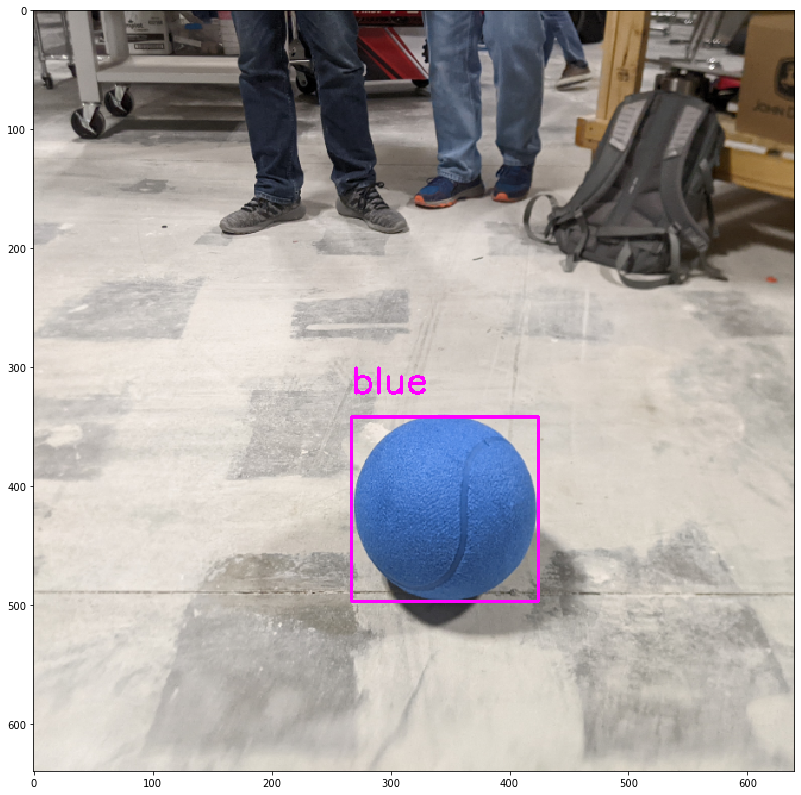

In [162]:
color = (255, 0, 255)
drawimg = crop.copy()
for i in range(len(result_class_ids)):
    box = result_boxes[i]
    cv2.rectangle(drawimg, box, color, 2)
    if result_class_ids[i] == 0:
        class_str = 'red'
    else:
        class_str = 'blue'
    cv2.putText(drawimg, class_str, (box[0], box[1] - 20), cv2.FONT_HERSHEY_SIMPLEX, 1.0, color, 2)
show(drawimg)